## Attention Mechanism

In [1]:
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
path = tf.keras.utils.get_file("spa-eng.zip", url, cache_dir="extras/.", extract=True)
text = (pathlib.Path(path).with_name("spa-eng") / "spa.txt").read_text()
text = text.replace("¡", "").replace("¿", "")
pairs = [line.split("\t") for line in text.splitlines()]
np.random.seed(42)
np.random.shuffle(pairs)
sentences_en, sentences_es = zip(*pairs)

In [3]:
for i in range(5):
    print(sentences_en[i], "==>", sentences_es[i])

How boring! ==> Qué aburrimiento!
I love sports. ==> Adoro el deporte.
Would you like to swap jobs? ==> Te gustaría que intercambiemos los trabajos?
My mother did nothing but weep. ==> Mi madre no hizo nada sino llorar.
Croatia is in the southeastern part of Europe. ==> Croacia está en el sudeste de Europa.


In [ ]:
vocab_size = 1_000
max_length = 50
text_vec_en = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length
)
text_vec_es = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length
)
text_vec_en.adapt(sentences_en)
text_vec_es.adapt([f"<sos> {s} <eos>" for s in sentences_es])

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
embed_size = 128

encoder_input = tf.keras.Input([], dtype=tf.string)
decoder_input = tf.keras.Input([], dtype=tf.string)
encoder_input_ids = text_vec_en(encoder_input)
decoder_input_ids = text_vec_es(decoder_input)
encoder_embed_layer = tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True)
decoder_embed_layer = tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True)
encoder_embeddings = encoder_embed_layer(encoder_input_ids)
decoder_embeddings = decoder_embed_layer(decoder_input_ids)

<hr>

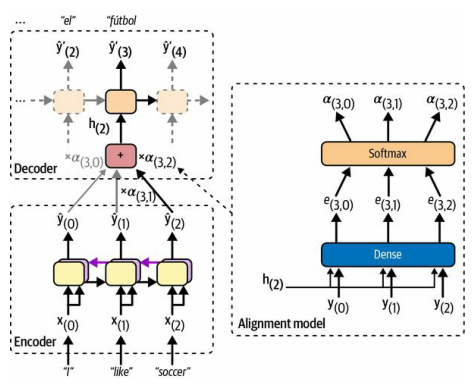

In [8]:
img = tf.io.read_file("extras/attention.png")
img = tf.io.decode_png(img)
ax = plt.axes()
ax.axis("off")
ax.imshow(img);

On the left, you have the encoder and the decoder. Instead of just
sending the encoder’s final hidden state to the decoder, as well as the
previous target word at each step (which is still done, although it is not shown
in the figure), we now send *all of the encoder’s outputs to the decoder as
well*. Since the decoder cannot deal with all these encoder outputs at once,
they need to be **aggregated**: at each time step, the decoder’s memory cell
computes a weighted sum of all the encoder outputs.

Keras provides a `tf.keras.layers.Attention` layer for **Luong** attention, and an
`AdditiveAttention` layer for **Bahdanau** attention. Let’s add Luong attention to
our encoder–decoder model. Since we will need to pass all the encoder’s
outputs to the Attention layer, we first need to set return_sequences=True
when creating the encoder

In [ ]:
tf.random.set_seed(42)
tf.keras.backend.clear_session()

encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_sequences=True, return_state=True)
)
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [
    tf.concat(encoder_state[::2], axis=-1),
    tf.concat(encoder_state[1::2], axis=-1),
]
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

In [10]:
attention_layer = tf.keras.layers.Attention()
attention_outputs = attention_layer([encoder_outputs, decoder_outputs])
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(attention_outputs)

In [ ]:
from IPython.display import display, Markdown

code = """
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))
"""
display(Markdown("```python\n\n{}".format(code)))

```python


model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))
